In [1]:
import tensorflow as tf
import os
import numpy as np
import random
SEED = 0
#------------------------------------------------------------------------------------
def set_seeds(seed=SEED):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)
#------------------------------------------------------------------------------------
def set_global_determinism(seed=SEED):
    set_seeds(seed=seed)

    os.environ['TF_DETERMINISTIC_OPS'] = '-1'
    os.environ['TF_CUDNN_DETERMINISTIC'] = '-1'
    
    tf.config.threading.set_inter_op_parallelism_threads(1)
    tf.config.threading.set_intra_op_parallelism_threads(1)

# Call the above function with seed value
set_global_determinism(seed=SEED)
#-----------------------------------------------------------------------------------

In [2]:
%matplotlib notebook
import pandas as pd
from data_extraction import *
from resp_signal_extraction import *
from rr_extration import *
from sklearn.preprocessing import MinMaxScaler
import re
import pickle as pkl
from tf_model import *
from tf_model_new import *
from tf_model_evi import *
from tf_model_attn_monte import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import Huber
import matplotlib.pyplot as plt
from filters import *
import tqdm
import plotly as py
import plotly.figure_factory as ff
import ipywidgets as widgets
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
py.offline.init_notebook_mode(connected = True)
from plotly import tools
import plotly.express as px
import time
import sys

In [3]:
input_conf = 'confd'

In [4]:
with open('output','rb') as f:
    output_data = pkl.load(f)

with open('input','rb') as f:
    input_data = pkl.load(f)

with open('raw_signal.pkl','rb') as f:
    raw_data = pkl.load(f)

input_data = np.transpose(input_data, (0,2,1))
raw_data = np.transpose(raw_data, (0,2,1))
annotation = pd.read_pickle('/media/acrophase/pose1/charan/BR_Uncertainty/ATTENTION/annotation.pkl')
print(annotation)
#sys.exit()
reference_rr = (annotation['Reference_RR'].values).reshape(-1,1)

input_data = np.around(input_data , decimals = 4)
raw_data = np.around(raw_data , decimals = 4)
output_data = np.around(output_data , decimals = 4)
reference_rr = np.around(reference_rr , decimals = 4)

tensor_input = tf.convert_to_tensor(input_data, dtype = 'float32')
tensor_output = tf.convert_to_tensor(output_data, dtype = 'float32')
tensor_ref_rr = tf.convert_to_tensor(reference_rr, dtype = 'float32')
tensor_raw_data = tf.convert_to_tensor(raw_data, dtype = 'float32')
training_ids = annotation['patient_id'] < 13

x_train_data = tensor_input[tf.convert_to_tensor(training_ids.values)]
x_test_data = tensor_input[tf.convert_to_tensor(~(training_ids.values))]
x_train_ref_rr = tensor_ref_rr[tf.convert_to_tensor(training_ids.values)]
x_test_ref_rr = tensor_ref_rr[tf.convert_to_tensor(~(training_ids.values))]
x_train_raw_sig = tensor_raw_data[tf.convert_to_tensor(training_ids.values)]
x_test_raw_sig = tensor_raw_data[tf.convert_to_tensor(~(training_ids.values))]

y_train_data = tensor_output[tf.convert_to_tensor(training_ids.values)]
y_test_data = tensor_output[tf.convert_to_tensor(~(training_ids.values))]

      Reference_RR  activity_id  patient_id
0        21.052632          5.0         1.0
1        22.018349          5.0         1.0
2        14.358974          5.0         1.0
3        11.764706          0.0         1.0
4        14.608696          0.0         1.0
...            ...          ...         ...
3878     15.000000          1.0         9.0
3879     16.991150          1.0         9.0
3880     15.700935          1.0         9.0
3881     15.412844          1.0         9.0
3882     23.529412          1.0         9.0

[3883 rows x 3 columns]


2022-04-06 13:27:00.525261: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-06 13:27:00.532117: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-06 13:27:00.532632: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-06 13:27:00.533641: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [5]:


if input_conf == 'confd':
        train_dataset = tf.data.Dataset.from_tensor_slices((x_train_data , y_train_data, x_train_ref_rr))
        train_dataset = train_dataset.shuffle(len(x_train_data)).batch(128)
        test_dataset = tf.data.Dataset.from_tensor_slices((x_test_data , y_test_data, x_test_ref_rr))
        test_dataset = test_dataset.batch(1)


if input_conf == 'confe':
        train_dataset = tf.data.Dataset.from_tensor_slices((x_train_raw_sig , y_train_data))
        train_dataset = train_dataset.shuffle(len(x_train_raw_sig)).batch(128)
        test_dataset = tf.data.Dataset.from_tensor_slices((x_test_raw_sig , y_test_data))
        test_dataset = test_dataset.batch(1)


In [6]:
#-----------------------------------------------------------------------------------------------------------------
if input_conf == 'confd':
    model_input_shape = (128,3)
    model  = BRUnet_Multi_resp(model_input_shape)
    loss_fn = Huber()
    model(tf.ones((128,128,3)))
    model.load_weights('/media/acrophase/pose1/charan/BR_Uncertainty/ATTENTION/SAVED_MODEL_WO_ATT/confd/best_model_10.01_0.0001_100.h5')
    test_loss_list = []
    final_output = tf.convert_to_tensor([])
    final_output_rr = tf.convert_to_tensor([])
    bottle_neck_wo_attn = tf.convert_to_tensor([])
    start_full = time.time()
    cnt = 0
    total_time = 0
    for step , (x_batch_test,y_batch_test,x_batch_test_ref_rr) in enumerate(test_dataset):
        
        cnt += 1
        start = time.time()
        #print(x_batch_test.shape)
        test_output,test_out_rr,bttl_neck = model(x_batch_test)
        end = time.time()
        test_loss_resp = loss_fn(y_batch_test  , test_output)
        test_loss_rr = loss_fn(x_batch_test_ref_rr , test_out_rr)
        test_loss = test_loss_resp + test_loss_rr
        if step == 0:
            final_output = test_output
            final_output_rr = test_out_rr
            bottle_neck_wo_attn = bttl_neck
        else:
            final_output = tf.concat([final_output , test_output] , axis = 0)
            final_output_rr = tf.concat([final_output_rr , test_out_rr] , axis = 0)
            bottle_neck_wo_attn = tf.concat([bottle_neck_wo_attn , bttl_neck] , axis = 0)
        test_loss_list.append(test_loss)
        total_time += (end-start)
        #print(end-start)
    end_full = time.time()
    model.summary()
    #print(end_full - start_full)
    #print(cnt)
    print(total_time/cnt)
#------------------------------------------------------------------------------------------------------------------

#--------------------------------------------------------------------------------------------------------------------
if input_conf == 'confe':
    model_input_shape = (2048,3)
    model  = BRUnet_raw(model_input_shape)
    loss_fn = Huber()
    model(tf.ones((128,2048,3)))
    model.load_weights('/media/acrophase/pose1/charan/BR_Uncertainty/ATTENTION/SAVED_MODEL_WO_ATT/confe/best_model_60.001_0.0001_100.h5')
    test_loss_list = []
    final_output = tf.convert_to_tensor([])
    cnt = 0
    total_time = 0
    start_full = time.time()
    for step , (x_batch_test_raw,y_batch_test) in enumerate(test_dataset):
        
        cnt+=1
        start = time.time()
        output = model(x_batch_test_raw)
        end = time.time()
        test_loss = loss_fn(y_batch_test , output)
        if step == 0:
            final_output = output
        else:
            final_output = tf.concat([final_output , output] , axis = 0)
        test_loss_list.append(test_loss)
        total_time+=(end-start)
        #print(end-start)
    end_full = time.time()
    model.summary()
    print(end_full - start_full)
    print(cnt)
    print(total_time/cnt)
    #print(end_full)
    #if(cnt <= 2):
     #   print((end-start))


2022-04-06 13:27:02.129477: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8101
2022-04-06 13:27:02.982678: I tensorflow/stream_executor/cuda/cuda_blas.cc:1760] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


Model: "br_unet__multi_resp"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_4 (Sequential)    (None, 64, 32)            15136     
_________________________________________________________________
sequential_9 (Sequential)    (None, 32, 64)            64640     
_________________________________________________________________
sequential_14 (Sequential)   (None, 16, 128)           224000    
_________________________________________________________________
sequential_19 (Sequential)   (None, 8, 256)            957952    
_________________________________________________________________
sequential_24 (Sequential)   (None, 8, 512)            3562496   
_________________________________________________________________
sequential_29 (Sequential)   (None, 8, 1024)           11088896  
_________________________________________________________________
sequential_34 (Sequential)   (None, 4, 128)    

In [7]:
def extremas_extraction(signal):
    avg_breath_duration = np.array([])
    extrema_relevent = []
    for item in signal:
        amplitude = np.array([])
        pos_peaks , _ = scipy.signal.find_peaks(item , height = [-3000,3000])
        neg_peaks , _ = scipy.signal.find_peaks(-1*item , height = [-3000 , 3000])
        extremas = np.concatenate((pos_peaks , neg_peaks))
        extremas = np.sort(extremas)
        for i in range(len(extremas)):
            amplitude = np.append(amplitude , item[int(extremas[i])])
        amplitude_diff = np.abs(np.diff(amplitude))
        q3 = np.percentile(amplitude_diff , 75)
        threshold = 0.3*q3
        eliminate_pairs_of_extrema = 1
        while(eliminate_pairs_of_extrema):
            amps = np.array([])
            if len(extremas)<3:
                eliminate_pairs_of_extrema = 0
                continue
            for i in range(len(extremas)):
                amps = np.append(amps , item[int(extremas[i])])
            amp_diff = np.abs(np.diff(amps)) 
            min_amp_diff , index = min(amp_diff) , np.argmin(amp_diff)
            #print(min_amp_diff)
            if min_amp_diff > threshold:
                eliminate_pairs_of_extrema = 0
                #extrema_relevent = extremas
            else:
                extremas = np.concatenate((extremas[0:index] , extremas[index+2 :]))
                #amplitude_diff = np.delete(amplitude_diff , index)
        if item[int(extremas[0])] < item[int(extremas[1])]:
            extremas = extremas[1:]
        if item[int(extremas[-1])] < item[int(extremas[-2])]:
            extremas = extremas[:-1]
        no_of_breaths = (len(extremas)-1)/2
        breath_duration = extremas[-1] - extremas[0]
        avg_breath_duration = np.append(avg_breath_duration , breath_duration/no_of_breaths)
        extrema_relevent.append(extremas)
    return avg_breath_duration , extrema_relevent

In [8]:
ref_sig = y_test_data.numpy()
fbpB , fbpA = band_pass(0.1,0.7,8)
final_ref_resp_sig = []
for item in ref_sig:
    final_ref_resp_sig.append(scipy.signal.filtfilt(fbpB,fbpA , item))
final_ref_resp_sig = np.array(final_ref_resp_sig)

In [9]:


#--------------------------------------------------------------------------------------------------------------------    
if input_conf == 'confe':
    final_output_resp_sig = []
    inst_br_dur = []
    inst_ref_br_dur = []
    inst_rr = []
    inst_ref_rr = []
    final_output_resp = final_output.numpy()
    final_output_resp = final_output_resp.reshape(final_output_resp.shape[0],final_output_resp.shape[1])
    for item in final_output_resp:
        final_output_resp_sig.append(scipy.signal.filtfilt(fbpB,fbpA , item))
    final_output_resp_sig = np.array(final_output_resp_sig)
    duration_resp,extremas_resp = extremas_extraction(final_output_resp_sig)
    duration_ref_resp,extremas_ref_resp = extremas_extraction(final_ref_resp_sig)
    avg_breaths = (60*4/duration_resp).reshape(-1,1)
    avg_ref_breath = (60*4/duration_ref_resp).reshape(-1,1)
    
    error_avg_breaths = np.abs(avg_ref_breath - avg_breaths)
    mae_avg_breath = np.mean(error_avg_breaths)
    rmse_avg_breath = np.sqrt(np.mean(error_avg_breaths**2))
    
    for item in extremas_resp:
        inst_br_dur.append(np.diff(item[0::2]))
    for item in extremas_ref_resp:
        inst_ref_br_dur.append(np.diff(item[0::2]))
    for item in inst_br_dur:
        inst_rr.append(np.mean(60*4/item))
    for item in inst_ref_br_dur:
        inst_ref_rr.append(np.mean(60*4/item))
    
    inst_rr = (np.array(inst_rr)).reshape(-1,1)
    inst_ref_rr = (np.array(inst_ref_rr)).reshape(-1,1)
    
    error_inst_breaths = np.abs(inst_ref_rr - inst_rr)
    mae_inst_breath = np.mean(error_inst_breaths)
    rmse_inst_breath = np.sqrt(np.mean(error_inst_breaths**2))
    
    print('Mean Absolute Error average wise for {} is: {}'.format(input_conf,mae_avg_breath))
    print('Root Mean Square Error average wise for {} is: {}'.format(input_conf,rmse_avg_breath))
    
    print('Mean Absolute Error instantaneous wise for {} is: {}'.format(input_conf,mae_inst_breath))
    print('Root Mean Square Error instantaneous wise for {} is: {}'.format(input_conf,rmse_inst_breath))

In [10]:
if input_conf == 'confd':
    final_output_resp_sig = []
    inst_br_dur = []
    inst_ref_br_dur = []
    inst_rr = []
    inst_ref_rr = []
    
    final_output_resp = final_output.numpy()
    final_rr = final_output_rr.numpy()
    final_output_resp = final_output_resp.reshape(final_output_resp.shape[0],final_output_resp.shape[1])
    final_rr = final_rr.reshape(final_rr.shape[0],final_rr.shape[1])
    for item in final_output_resp:
        final_output_resp_sig.append(scipy.signal.filtfilt(fbpB,fbpA , item))
        
    final_output_resp_sig = np.array(final_output_resp_sig)
    duration_resp,extremas_resp = extremas_extraction(final_output_resp_sig)
    duration_ref_resp,extremas_ref_resp = extremas_extraction(final_ref_resp_sig)
    avg_ref_breath = (60*4/duration_ref_resp).reshape(-1,1)
    
    error_avg_breaths = np.abs(avg_ref_breath - final_rr)
    mae_avg_breath = np.mean(error_avg_breaths)
    rmse_avg_breath = np.sqrt(np.mean(error_avg_breaths**2))
    
    for item in extremas_resp:
        inst_br_dur.append(np.diff(item[0::2]))
    for item in extremas_ref_resp:
        inst_ref_br_dur.append(np.diff(item[0::2]))
    for item in inst_br_dur:
        inst_rr.append(np.mean(60*4/item))
    for item in inst_ref_br_dur:
        inst_ref_rr.append(np.mean(60*4/item))
    
    inst_rr = (np.array(inst_rr)).reshape(-1,1)
    inst_ref_rr = (np.array(inst_ref_rr)).reshape(-1,1)
    
    error_inst_breaths = np.abs(inst_ref_rr - inst_rr)
    mae_inst_breath = np.mean(error_inst_breaths)
    rmse_inst_breath = np.sqrt(np.mean(error_inst_breaths**2))
    error_wo_att_block = error_inst_breaths
    signal_wo_attn = final_output_resp_sig
    extremas_wo_attn = extremas_resp
    print('Mean Absolute Error average wise for {} is: {}'.format(input_conf,mae_avg_breath))
    print('Root Mean Square Error average wise for {} is: {}'.format(input_conf,rmse_avg_breath))
    
    print('Mean Absolute Error instantaneous wise for {} is: {}'.format(input_conf,mae_inst_breath))
    print('Root Mean Square Error instantaneous wise for {} is: {}'.format(input_conf,rmse_inst_breath))

#-------------------------------------------------------------------------------------------------------


Mean Absolute Error average wise for confd is: 2.369817459095249
Root Mean Square Error average wise for confd is: 2.9670212960083866
Mean Absolute Error instantaneous wise for confd is: 3.424704443944356
Root Mean Square Error instantaneous wise for confd is: 4.3119720418668


In [11]:
np.argmax(error_inst_breaths)

637

In [12]:
start_basic = time.time()
edr_hrv = [np.array([]) for i in range(len(x_test_data))]
edr_rpeak = [np.array([]) for i in range(len(x_test_data))]
adr = [np.array([]) for i in range(len(x_test_data))]
for i in range(len(x_test_data)):
    arr = np.transpose(x_test_data[i])
    edr_hrv[i]=np.append(edr_hrv[i],arr[0])
    edr_rpeak[i]=np.append(edr_rpeak[i],arr[1])
    adr[i]=np.append(adr[i],arr[2])

In [13]:
final_edr_hrv = []
final_edr_rpeak = []
final_adr = []
for i in range(len(edr_hrv)):
    final_edr_hrv.append(scipy.signal.filtfilt(fbpB,fbpA , edr_hrv[i]))
    final_edr_rpeak.append(scipy.signal.filtfilt(fbpB,fbpA , edr_rpeak[i]))
    final_adr.append(scipy.signal.filtfilt(fbpB,fbpA , adr[i]))

In [14]:
hrv_duration , extremas_hrv = extremas_extraction(final_edr_hrv)
rpeak_duration , extremas_rpeak = extremas_extraction(final_edr_rpeak)
adr_duration , extremas_adr = extremas_extraction(final_adr)


In [15]:
rr_hrv = (60*4)/hrv_duration.reshape(-1,1)
rr_rpeak = (60*4)/rpeak_duration.reshape(-1,1)
rr_adr = (60*4)/adr_duration.reshape(-1,1)

error_hrv = np.abs(rr_hrv - avg_ref_breath)
error_rpeak = np.abs(rr_rpeak - avg_ref_breath)
error_adr = np.abs(rr_adr - avg_ref_breath)
end_basic = time.time()

print(end_basic - start_basic)

2.3194656372070312


In [16]:
mae_hrv = np.mean(error_hrv)
mae_rpeak = np.mean(error_rpeak)
mae_adr = np.mean(error_adr)

print(mae_hrv)
print(mae_rpeak)
print(mae_adr)

3.266529397156253
3.468155060676451
3.152974735868695


# WITH ATTENTION BLOCK

In [17]:
     
#-----------------------------------------------------------------------------------------------------------------
if input_conf == 'confd':
    model_input_shape = (128,3)
    model  = BRUnet_Multi_resp_ATT(model_input_shape)
    loss_fn = Huber()
    model(tf.ones((128,128,3)))
    model.load_weights('/media/acrophase/pose1/charan/BR_Uncertainty/ATTENTION/SAVED_MODELS_WITH_ATT/confd/best_model_30.01_0.0001_100.h5')
    test_loss_list = []
    final_output = tf.convert_to_tensor([])
    final_output_rr = tf.convert_to_tensor([])
    attn1 = tf.convert_to_tensor([])
    attn2 = tf.convert_to_tensor([])
    attn3 = tf.convert_to_tensor([])
    attn4 = tf.convert_to_tensor([])
    attn5 = tf.convert_to_tensor([])
    attn6 = tf.convert_to_tensor([])
    attn7 = tf.convert_to_tensor([])
    attn8 = tf.convert_to_tensor([])
    attn9 = tf.convert_to_tensor([])
    bottle_neck_with_attn = tf.convert_to_tensor([])
    start_att = time.time()
    cnt = 0
    for step , (x_batch_test,y_batch_test,x_batch_test_ref_rr) in enumerate(test_dataset):
        cnt+=1
        test_output,test_out_rr,at_1,at_2,at_3,at_4,at_5,at_6,at_7,at_8,at_9,bttl_neck = model(x_batch_test)
        test_loss_resp = loss_fn(y_batch_test  , test_output)
        test_loss_rr = loss_fn(x_batch_test_ref_rr , test_out_rr)
        test_loss = test_loss_resp + test_loss_rr
        if step == 0:
            final_output = test_output
            final_output_rr = test_out_rr
            attn1 = at_1
            attn2 = at_2
            attn3 = at_3
            attn4 = at_4
            attn5 = at_5
            attn6 = at_6
            attn7 = at_7
            attn8 = at_8
            attn9 = at_9
            bottle_neck_with_attn = bttl_neck
        else:
            final_output = tf.concat([final_output , test_output] , axis = 0)
            final_output_rr = tf.concat([final_output_rr , test_out_rr] , axis = 0)
            attn1 = tf.concat([attn1 , at_1] , axis = 0)
            attn2 = tf.concat([attn2 , at_2] , axis = 0)
            attn3 = tf.concat([attn3 , at_3] , axis = 0)
            attn4 = tf.concat([attn4 , at_4] , axis = 0)
            attn5 = tf.concat([attn5 , at_5] , axis = 0)
            attn6 = tf.concat([attn6 , at_6] , axis = 0)
            attn7 = tf.concat([attn7 , at_7] , axis = 0)
            attn8 = tf.concat([attn8 , at_8] , axis = 0)
            attn9 = tf.concat([attn9 , at_9] , axis = 0)
            bottle_neck_with_attn = tf.concat([bottle_neck_with_attn , bttl_neck] , axis = 0)
        test_loss_list.append(test_loss)
    end_att = time.time()
    model.summary()
    print(cnt)
    print((end_att-start_att)/cnt)
            


Model: "br_unet__multi_resp_att"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_82 (Sequential)   (None, 64, 32)            15136     
_________________________________________________________________
sequential_87 (Sequential)   (None, 32, 64)            64640     
_________________________________________________________________
sequential_92 (Sequential)   (None, 16, 128)           224000    
_________________________________________________________________
sequential_97 (Sequential)   (None, 8, 256)            957952    
_________________________________________________________________
sequential_102 (Sequential)  (None, 8, 512)            3562496   
_________________________________________________________________
sequential_107 (Sequential)  (None, 8, 1024)           11088896  
_________________________________________________________________
attention_block (AttentionBl multiple      

In [18]:
if input_conf == 'confd':
    final_output_resp_sig = []
    inst_br_dur = []
    inst_ref_br_dur = []
    inst_rr = []
    inst_ref_rr = []
    
    final_output_resp = final_output.numpy()
    final_rr = final_output_rr.numpy()
    final_output_resp = final_output_resp.reshape(final_output_resp.shape[0],final_output_resp.shape[1])
    final_rr = final_rr.reshape(final_rr.shape[0],final_rr.shape[1])
    for item in final_output_resp:
        final_output_resp_sig.append(scipy.signal.filtfilt(fbpB,fbpA , item))
        
    final_output_resp_sig = np.array(final_output_resp_sig)
    duration_resp,extremas_resp = extremas_extraction(final_output_resp_sig)
    duration_ref_resp,extremas_ref_resp = extremas_extraction(final_ref_resp_sig)
    avg_ref_breath = (60*4/duration_ref_resp).reshape(-1,1)
    
    error_avg_breaths = np.abs(avg_ref_breath - final_rr)
    mae_avg_breath = np.mean(error_avg_breaths)
    rmse_avg_breath = np.sqrt(np.mean(error_avg_breaths**2))
    
    for item in extremas_resp:
        inst_br_dur.append(np.diff(item[0::2]))
    for item in extremas_ref_resp:
        inst_ref_br_dur.append(np.diff(item[0::2]))
    for item in inst_br_dur:
        inst_rr.append(np.mean(60*4/item))
    for item in inst_ref_br_dur:
        inst_ref_rr.append(np.mean(60*4/item))
    
    inst_rr = (np.array(inst_rr)).reshape(-1,1)
    inst_ref_rr = (np.array(inst_ref_rr)).reshape(-1,1)
    
    error_inst_breaths = np.abs(inst_ref_rr - inst_rr)
    mae_inst_breath = np.mean(error_inst_breaths)
    rmse_inst_breath = np.sqrt(np.mean(error_inst_breaths**2))
    error_with_att_block = error_inst_breaths
    signal_with_attn = final_output_resp_sig
    extremas_with_attn = extremas_resp
    print('Mean Absolute Error average wise for {} is: {}'.format(input_conf,mae_avg_breath))
    print('Root Mean Square Error average wise for {} is: {}'.format(input_conf,rmse_avg_breath))
    
    print('Mean Absolute Error instantaneous wise for {} is: {}'.format(input_conf,mae_inst_breath))
    print('Root Mean Square Error instantaneous wise for {} is: {}'.format(input_conf,rmse_inst_breath))

#-------------------------------------------------------------------------------------------------------

Mean Absolute Error average wise for confd is: 2.368042903899399
Root Mean Square Error average wise for confd is: 2.979479269770928
Mean Absolute Error instantaneous wise for confd is: 3.16513222814529
Root Mean Square Error instantaneous wise for confd is: 3.9869473859041524


In [78]:
np.argmin(error_inst_breaths)

138

In [19]:
final_attn1 = attn1.numpy()
final_attn2 = attn2.numpy()
final_attn3 = attn3.numpy()
final_attn4 = attn4.numpy()
final_attn5 = attn5.numpy()
final_attn6 = attn6.numpy()
final_attn7 = attn7.numpy()
final_attn8 = attn8.numpy()
final_attn9 = attn9.numpy()
final_bn_with_attn = bottle_neck_with_attn.numpy()
final_bn_wo_attn = bottle_neck_wo_attn.numpy()

In [20]:
new_attn5 = final_attn5.transpose(0,2,1)
new_attn6 = final_attn6.transpose(0,2,1)
new_attn7 = final_attn7.transpose(0,2,1)
new_attn8 = final_attn8.transpose(0,2,1)
new_attn9 = final_attn9.transpose(0,2,1)
new_attn1 = final_attn1.transpose(0,2,1)
new_btl_wo_attn = final_bn_wo_attn.transpose(0,2,1)
new_btl_with_attn = final_bn_with_attn.transpose(0,2,1)

In [21]:
x_attn1 = new_attn1[0][2]
x_attn5 = new_attn5[0][0]
x_attn6 = new_attn6[0][0]
x_attn7 = new_attn7[0][0] #5
x_attn8 = new_attn8[0][0] #8,11,12,13
x_attn9 = new_attn9[0][2]
x_wo_attn = new_btl_wo_attn[0][5]
x_with_attn = new_btl_with_attn[0][2]


x_attn1 = (x_attn1 - min(x_attn1))/(max(x_attn1) - min(x_attn1))
x_attn5 = (x_attn5 - min(x_attn5))/(max(x_attn5) - min(x_attn5))
x_attn6 = (x_attn6 - min(x_attn6))/(max(x_attn6) - min(x_attn6))
x_attn7 = (x_attn7 - min(x_attn7))/(max(x_attn7) - min(x_attn7))
x_attn8 = (x_attn8 - min(x_attn8))/(max(x_attn8) - min(x_attn8))
x_attn9 = (x_attn9 - min(x_attn9))/(max(x_attn9) - min(x_attn9))
x_with_attn = (x_with_attn - min(x_with_attn))/(max(x_with_attn) - min(x_with_attn))

In [22]:
x_attn7.shape

(16,)

<IPython.core.display.Javascript object>


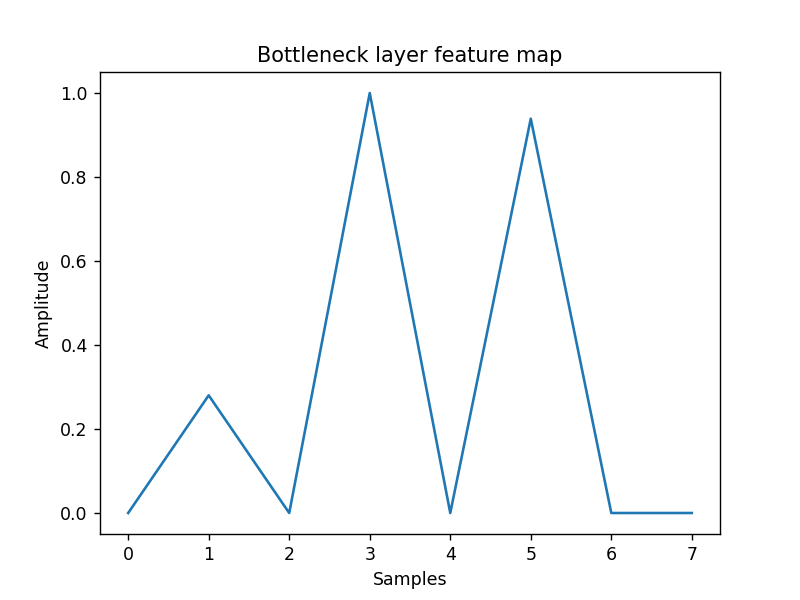

<IPython.core.display.Javascript object>


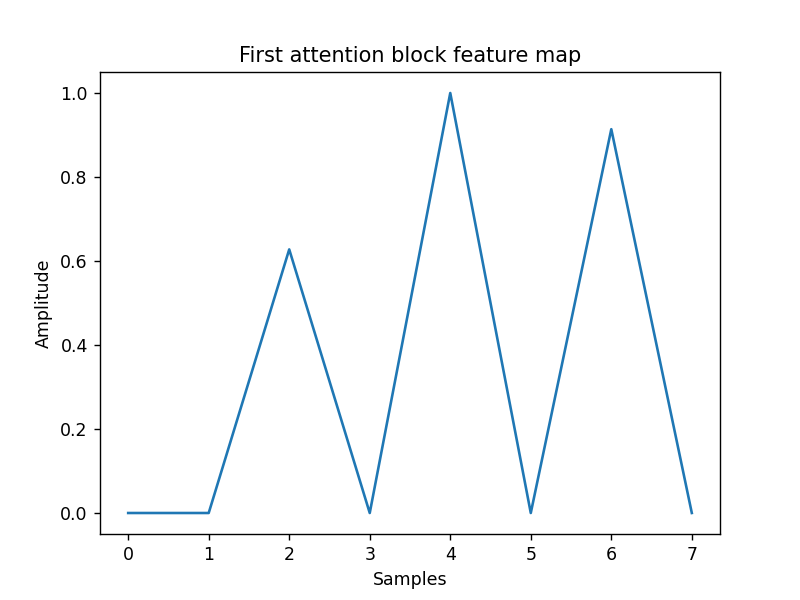

<IPython.core.display.Javascript object>


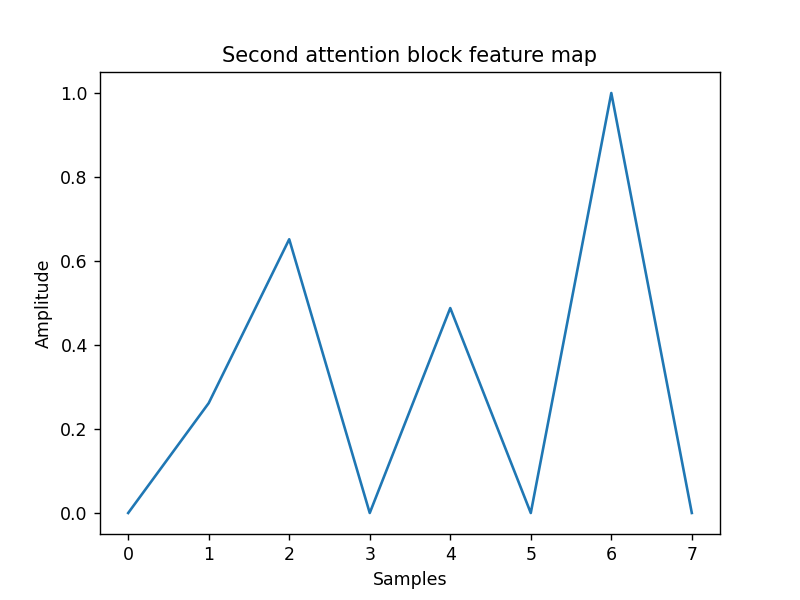

<IPython.core.display.Javascript object>


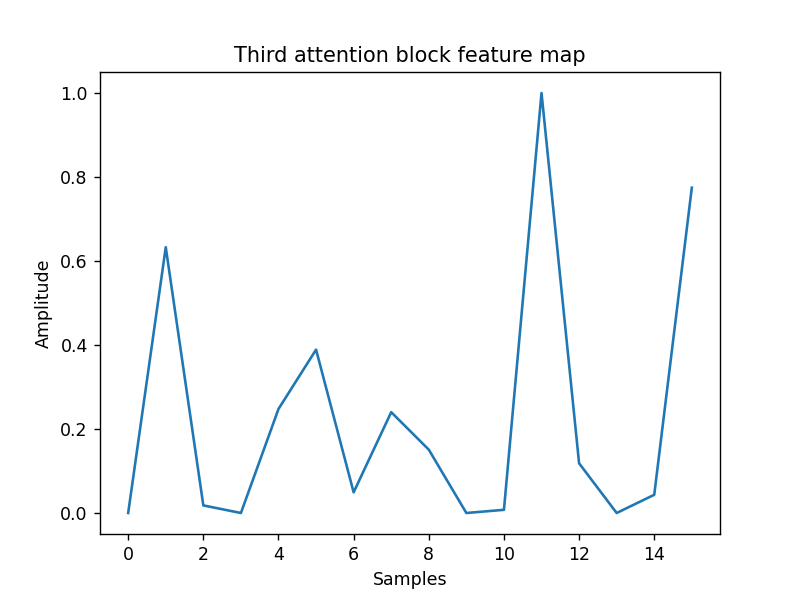

<IPython.core.display.Javascript object>


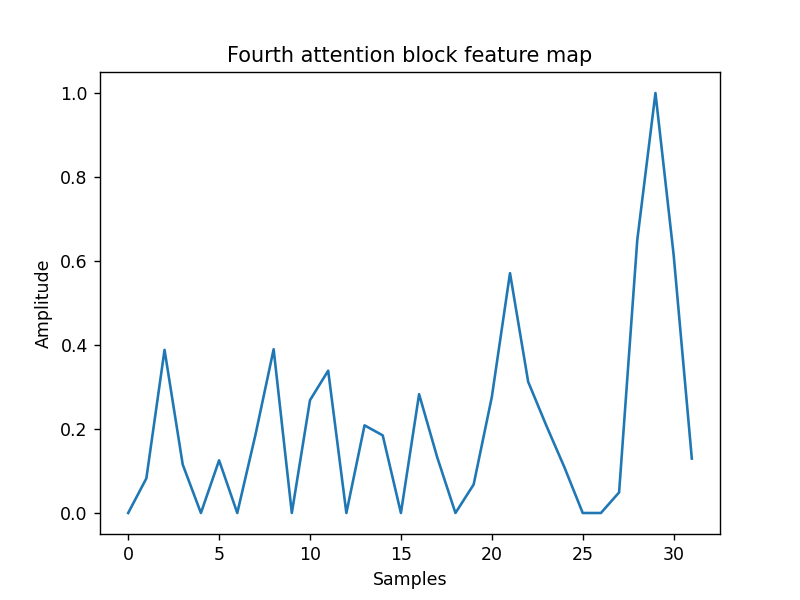

<IPython.core.display.Javascript object>


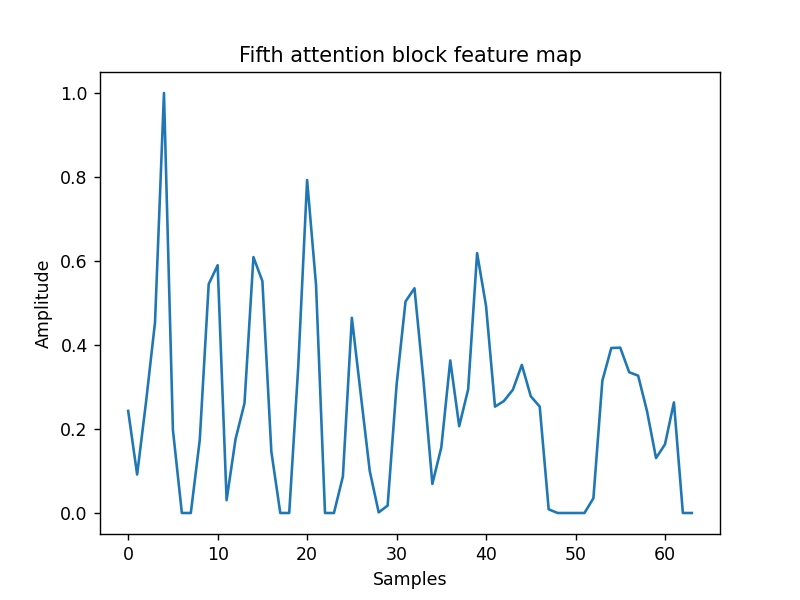

In [23]:
plt.figure(1)
plt.plot(x_attn1)
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.title("Bottleneck layer feature map")
plt.savefig('bottleneck_feat.jpg')
plt.show()

plt.figure(2)
plt.plot(x_attn5)
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.title("First attention block feature map")
plt.savefig('firstattn_feat.jpg')
plt.show()

plt.figure(3)
plt.plot(x_attn6)
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.title("Second attention block feature map")
plt.savefig('secondattn_feat.jpg')
plt.show()

plt.figure(4)
plt.plot(x_attn7)
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.title("Third attention block feature map")
plt.savefig('thirdattn_feat.jpg')
plt.show()

plt.figure(5)
plt.plot(x_attn8)
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.title("Fourth attention block feature map")
plt.savefig('fourthattn_feat.jpg')
plt.show()

plt.figure(6)
plt.plot(x_attn9)
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.title("Fifth attention block feature map")
plt.savefig('fifthattn_feat.jpg')
plt.show()

In [24]:
def dist_trans(patient_ref):
    distance_transform = []
    for i in tqdm.tqdm(range(len(patient_ref))):
        prev_qrs = patient_ref[i][0]
        next_qrs = patient_ref[i][1]
        dist_tran = np.zeros(128)
        beat_count = 1
        for j in range(len(dist_tran)):
            threshold = (prev_qrs + next_qrs)/2   
            if(j < threshold):
                dist_tran[j] = int(abs(j - prev_qrs))/250
            elif(j >= threshold): 
                dist_tran[j] = int(abs(j - next_qrs))/250
            if(j == next_qrs and beat_count != len(patient_ref[i])-1): ## -2 instead of -1 because we are incrementing the beat in the loop
                beat_count += 1 
                prev_qrs = next_qrs
                next_qrs = patient_ref[i][beat_count]
        distance_transform.append(dist_tran)
    distance_transform = np.asarray(distance_transform)
    scaler = MinMaxScaler(feature_range = (0,1))
    distance_transform =  np.transpose(scaler.fit_transform(distance_transform.transpose())) 
    return distance_transform

In [60]:

dist_with_attention = dist_trans(extremas_with_attn)
dist_wo_attention = dist_trans(extremas_wo_attn)
dist_ref_resp = dist_trans(extremas_ref_resp)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 814/814 [00:00<00:00, 8606.04it/s]


In [61]:
#xtremas_with_attn[0][::2]

In [69]:
w_at = extremas_with_attn
ref_at = extremas_ref_resp
wo_at = extremas_wo_attn

w_at_diff = []
wo_at_diff = []
for i in range(len(w_at)):
    w_at_diff.append(np.abs(len(w_at[i]) - len(ref_at[i])))

for j in range(len(wo_at)):
    wo_at_diff.append(np.abs(len(wo_at[j]) - len(ref_at[j])))

print(np.argmin(w_at_diff))
print(np.argmax(w_at_diff))

ind_w_at = []
ind_wo_at = []

for i in range(len(w_at_diff)):
    if(w_at_diff[i] == min(w_at_diff)):
        ind_w_at.append(i)

for j in range(len(w_at_diff)):
    if(wo_at_diff[j] == max(wo_at_diff)):
        ind_wo_at.append(j)

print(ind_w_at)
print(ind_wo_at)

0
313
[0, 4, 5, 22, 24, 33, 36, 55, 57, 63, 64, 65, 72, 76, 96, 102, 104, 109, 110, 117, 119, 120, 123, 127, 130, 157, 160, 163, 164, 167, 170, 174, 178, 179, 184, 187, 194, 196, 197, 198, 204, 206, 208, 217, 223, 224, 230, 233, 243, 245, 246, 247, 250, 252, 255, 261, 271, 272, 284, 289, 301, 302, 303, 307, 308, 336, 337, 338, 341, 342, 368, 375, 378, 390, 392, 398, 405, 415, 421, 426, 428, 429, 431, 434, 445, 452, 455, 459, 463, 467, 480, 483, 485, 506, 508, 519, 522, 537, 538, 546, 567, 568, 571, 574, 581, 584, 587, 596, 597, 607, 612, 614, 619, 628, 632, 645, 652, 657, 670, 675, 677, 679, 680, 686, 687, 690, 691, 705, 711, 712, 715, 716, 720, 726, 731, 735, 738, 739, 745, 746, 759, 763, 769, 773, 775, 776, 786, 787, 792, 796, 800, 802, 803, 808, 809]
[85, 99]


In [72]:
print(len(ref_at[99]))
print(len(wo_at[99]))

27
13


In [63]:
scaler = MinMaxScaler(feature_range = (0,1))
signal_with_attn = np.transpose(scaler.fit_transform(signal_with_attn.transpose()))
signal_wo_attn = np.transpose(scaler.fit_transform(signal_wo_attn.transpose()))
dist_with_attention = dist_with_attention-0.2
#signal_with_attn.ndim

In [64]:
#extremas_with_attn[240] = extremas_with_attn[240]+0.16

In [73]:

if input_conf == 'confd':
    no_of_samples = 32*4
    x_unc = np.linspace(start = 0,stop = no_of_samples, num = no_of_samples)
    layout_with_attn = go.Layout(
    title = "Respiratory Waveform with attention block ",
    yaxis = dict(
        title = 'Output Respiration Signal',
        title_font = dict(size = 16)
    ),
    xaxis = dict(
        title = 'Samples',
        title_font = dict(size = 16)
    ),
    legend=dict(
        x=0.75,
        y=1,
        traceorder='normal',
        font=dict(
            size=12),
    )   
    )
    
    layout_wo_attn = go.Layout(
    title = "Respiratory Waveform without attention block ",
    yaxis = dict(
        title = 'Output Respiration Signal',
        title_font = dict(size = 16)
    ),
    xaxis = dict(
        title = 'Samples',
        title_font = dict(size = 16)
    ),
    legend=dict(
        x=0.72,
        y=1,
        traceorder='normal',
        font=dict(
            size=12),
    ) 
    )
    
    layout_edr_hrv = go.Layout(
    title = "Plotting EDR Waveforms for ECG by HRV",
    yaxis = dict(
         title = 'Amplitude' 
    ),
    xaxis = dict(
        title = 'samples'
    )
    )

    layout_edr_rpeak = go.Layout(
        title = "Plotting EDR Waveforms for ECG by rpeak",
        yaxis = dict(
             title = 'Amplitude' 
        ),
        xaxis = dict(
            title = 'samples'
        )
    )

    layout_adr = go.Layout(
        title = "Plotting ADR waveforms for ACC",
        yaxis = dict(
             title = 'Amplitude' 
        ),
        xaxis = dict(
        title = 'samples'
        )
    )
    
    layout_resp = go.Layout(
    title = "Plotting resp signal waveforms for ref. resp. signal",
    yaxis = dict(
         title = 'Amplitude' 
    ),
    xaxis = dict(
        title = 'samples'
    )
    )

    
    def update_plot(signals):
        data = []
            # Reference ECG trace
        trace_with_attn = go.Scatter(
            x = x_unc,
            y = signal_with_attn[signals], 
            mode = 'lines',
            name = 'Respiration with Attention',
                    line = dict(
                    shape = 'spline',
                    color = 'black',
                    width = 3
                     ),
                #error_y=dict(
                #    type='data', # value of error bar given in data coordinates
                #    array=final_var[signals],
                #    visible=True,
                #    color='black',
                #thickness=3,
                #width=5)
                )
        trace_resp_extremas_with_attn = go.Scatter(
        x = extremas_with_attn[signals],
        y = signal_with_attn[signals][extremas_with_attn[signals]], 
        mode = 'markers',
        name = 'extremas',
        marker = dict(
                 size = 12,
                 color = 'red',
                 symbol = 'cross'
                 
             )
        )
        
        trace_dist_tran_with_attn = go.Scatter(
            x = x_unc,
            y = dist_with_attention[signals]-0.2, 
            mode = 'lines',
            name = 'Distance Transform',
                    line = dict(
                    shape = 'spline',
                    color = 'orange',
                    width = 3
                     ),
                #error_y=dict(
                #    type='data', # value of error bar given in data coordinates
                #    array=final_var[signals],
                #    visible=True,
                #    color='black',
                #thickness=3,
                #width=5)
                )
        
        
        trace_wo_attn = go.Scatter(
            x = x_unc,
            y = signal_wo_attn[signals], 
            mode = 'lines',
            name = 'Respiration without Attention',
                    line = dict(
                    shape = 'spline',
                    color = 'black',
                    width = 3
                     ),
                #error_y=dict(
                #    type='data', # value of error bar given in data coordinates
                #    array=final_var[signals],
                #    visible=True,
                #    color='black',
                #thickness=3,
                #width=5)
                )
        
        trace_resp_extremas_wo_attn = go.Scatter(
        x = extremas_wo_attn[signals],
        y = signal_wo_attn[signals][extremas_wo_attn[signals]], 
        mode = 'markers',
        name = 'extremas',
        marker = dict(
                 size = 12,
                 color = 'red',
                 symbol = 'cross'
                 
             )
        )

        trace_dist_tran_wo_attn = go.Scatter(
            x = x_unc,
            y = dist_wo_attention[signals], 
            mode = 'lines',
            name = 'Distance Transform',
                    line = dict(
                    shape = 'spline',
                    color = 'orange',
                    width = 3
                     ),
                #error_y=dict(
                #    type='data', # value of error bar given in data coordinates
                #    array=final_var[signals],
                #    visible=True,
                #    color='black',
                #thickness=3,
                #width=5)
                )   
        
        trace_dist_tran_ref = go.Scatter(
            x = x_unc,
            y = dist_ref_resp[signals], 
            mode = 'lines',
            name = 'Distance Transform',
                    line = dict(
                    shape = 'spline',
                    color = 'orange',
                    width = 3
                     ),
                #error_y=dict(
                #    type='data', # value of error bar given in data coordinates
                #    array=final_var[signals],
                #    visible=True,
                #    color='black',
                #thickness=3,
                #width=5)
                ) 
        trace_edr_hrv = go.Scatter(
             x = x_unc,
             y = final_edr_hrv[signals], 
             mode = 'lines',
             name = 'edr by hrv',
             line = dict(
                 shape = 'spline',
                 color = 'black',
                 width = 5
             )
        )
        trace_hrv_extremas = go.Scatter(
            x = extremas_hrv[signals],
            y = final_edr_hrv[signals][extremas_hrv[signals]], 
            mode = 'markers',
            name = 'extremas',
            marker = dict(
                 size = 8,
                 color = 'red',
                 symbol = 'circle'
                 
             )
            )
        
        trace_edr_rpeak = go.Scatter(
             x = x_unc,
             y = final_edr_rpeak[signals], 
             mode = 'lines',
             name = 'edr by rpeak',
             line = dict(
                 shape = 'spline',
                 color = 'black',
                 width = 5
             )
        )
    
        trace_rpeak_extremas = go.Scatter(
            x = extremas_rpeak[signals],
            y = final_edr_rpeak[signals][extremas_rpeak[signals]], 
            mode = 'markers',
            name = 'extremas',
            marker = dict(
                 size = 8,
                 color = 'red',
                 symbol = 'circle'
                 
             )
        )
        
        trace_adr = go.Scatter(
             x = x_unc,
             y = final_adr[signals], 
             mode = 'lines',
             name = 'adr from acc',
             line = dict(
                 shape = 'spline',
                 color = 'black',
                 width = 5
             )
        )
        trace_adr_extremas = go.Scatter(
            x = extremas_adr[signals],
            y = final_adr[signals][extremas_adr[signals]], 
            mode = 'markers',
            name = 'extremas',
            marker = dict(
                 size = 8,
                 color = 'red',
                 symbol = 'circle'
                 
             )
        )
        
        trace_resp = go.Scatter(
             x = x_unc,
             y = final_ref_resp_sig[signals], 
             mode = 'lines',
             name = 'reference resp signal',
             line = dict(
                 shape = 'spline',
                 color = 'black',
                 width = 5
             )
        )
        trace_resp_extremas = go.Scatter(
            x = extremas_ref_resp[signals],
            y = final_ref_resp_sig[signals][extremas_ref_resp[signals]], 
            mode = 'markers',
            name = 'extremas',
            marker = dict(
                 size = 8,
                 color = 'red',
                 symbol = 'circle'
                 
             )
            )
        
        fig_with_attn = go.Figure(data = [trace_with_attn,trace_resp_extremas_with_attn,trace_dist_tran_with_attn],layout = layout_with_attn)
        py.offline.iplot(fig_with_attn)
        fig_wo_attn = go.Figure(data = [trace_wo_attn,trace_resp_extremas_wo_attn,trace_dist_tran_wo_attn],layout = layout_wo_attn)
        py.offline.iplot(fig_wo_attn)
        fig_resp = go.Figure(data = [trace_resp , trace_resp_extremas,trace_dist_tran_ref],layout = layout_resp)
        py.offline.iplot(fig_resp)
        fig_edr_hrv = go.Figure(data = [trace_edr_hrv , trace_hrv_extremas],layout = layout_edr_hrv)
        py.offline.iplot(fig_edr_hrv)
        fig_edr_rpeak = go.Figure(data = [trace_edr_rpeak , trace_rpeak_extremas],layout = layout_edr_rpeak)
        py.offline.iplot(fig_edr_rpeak)
        fig_adr = go.Figure(data = [trace_adr , trace_adr_extremas],layout = layout_adr)
        py.offline.iplot(fig_adr)
        
signals_epsitemic = widgets.IntSlider(min = 0,max = len(signal_with_attn), value = 0, description = 'Record_no:')
widgets.interactive(update_plot, signals = signals_epsitemic)

interactive(children=(IntSlider(value=0, description='Record_no:', max=814), Output()), _dom_classes=('widget-…

In [129]:
fig0 = py.subplots.make_subplots(rows=2,cols=1,subplot_titles=("Fig. A", "Fig. B"),x_title='Samples',y_title='DT Amplitude')
fig0.append_trace(go.Scatter(
            x = x_unc,
            y = dist_with_attention[581], 
            mode = 'lines',
            name = 'DT with attention',
                    line = dict(
                    shape = 'spline',
                    color = 'green',
                    width = 3
                     ),
                #error_y=dict(
                #    type='data', # value of error bar given in data coordinates
                #    array=final_var[signals],
                #    visible=True,
                #    color='black',
                #thickness=3,
                #width=5)
                ), 1,1)

fig0.append_trace(go.Scatter(
            x = x_unc,
            y = dist_wo_attention[581], 
            mode = 'lines',
            name = 'DT w/o attention',
                    line = dict(
                    shape = 'spline',
                    color = 'red',
                    width = 3
                     ),
                #error_y=dict(
                #    type='data', # value of error bar given in data coordinates
                #    array=final_var[signals],
                #    visible=True,
                #    color='black',
                #thickness=3,
                #width=5)
                ), 1,1)
fig0.add_vrect(x0=64, x1=79)
fig0.append_trace(go.Scatter(
            x = x_unc,
            y = dist_ref_resp[581], 
            mode = 'lines',
            name = 'DT referece',
                    line = dict(
                    shape = 'spline',
                    color = 'black',
                    width = 3
                     ),
                #error_y=dict(
                #    type='data', # value of error bar given in data coordinates
                #    array=final_var[signals],
                #    visible=True,
                #    color='black',
                #thickness=3,
                #width=5)
                ), 2,1)
fig0.add_vrect(x0=64, x1=79)
fig0.update_layout(legend=dict(
    yanchor="bottom",
    y=0.2,
    xanchor="left",
    x=0.82
))
fig0.update_annotations(font_size=20)
fig0.show()


In [30]:
from plotly.offline import iplot
fig = py.subplots.make_subplots(rows=1,cols=1)
fig.append_trace(go.Scatter(
            x = x_unc,
            y = signal_with_attn[274], 
            mode = 'lines',
            name = 'Respiration waveform',
                    line = dict(
                    shape = 'spline',
                    color = 'black',
                    width = 3
                     ),
                #error_y=dict(
                #    type='data', # value of error bar given in data coordinates
                #    array=final_var[signals],
                #    visible=True,
                #    color='black',
                #thickness=3,
                #width=5)
                ), 1,1)
fig.append_trace(go.Scatter(
        x = extremas_with_attn[274]+0.3,
        y = signal_with_attn[274][extremas_with_attn[274]], 
        mode = 'markers',
        name = 'extremas',
        marker = dict(
                 size = 12,
                 color = 'red',
                 symbol = 'circle'
                 
             )
        ), 1,1)

fig.append_trace(go.Scatter(
            x = x_unc,
            y = dist_with_attention[274], 
            mode = 'lines',
            name = 'Distance Transform',
                    line = dict(
                    shape = 'spline',
                    color = 'orange',
                    width = 3
                     ),
                #error_y=dict(
                #    type='data', # value of error bar given in data coordinates
                #    array=final_var[signals],
                #    visible=True,
                #    color='black',
                #thickness=3,
                #width=5)
                ),1,1)
fig.update_xaxes(title_text="Samples", row=1, col=1)
fig.update_yaxes(title_text="Output Respiration Signal", row=1, col=1)
fig.update_yaxes(title_font=dict(size=18),tickfont = dict(size=16))
fig.update_xaxes(title_font=dict(size=18),tickfont = dict(size=16))

'''
fig.append_trace(go.Scatter(
            x = x_unc,
            y = signal_wo_attn[274], 
            mode = 'lines',
            name = 'Respiration without Attention',
                    line = dict(
                    shape = 'spline',
                    color = 'blue',
                    width = 3
                     ),
                #error_y=dict(
                #    type='data', # value of error bar given in data coordinates
                #    array=final_var[signals],
                #    visible=True,
                #    color='black',
                #thickness=3,
                #width=5)
                ), 1,2)
fig.append_trace(go.Scatter(
        x = extremas_wo_attn[274],
        y = signal_wo_attn[274][extremas_wo_attn[274]], 
        mode = 'markers',
        name = 'extremas',
        marker = dict(
                 size = 12,
                 color = 'red',
                 symbol = 'circle'
                 
             )
        ), 1,2)

fig.append_trace(go.Scatter(
            x = x_unc,
            y = dist_wo_attention[274], 
            mode = 'lines',
            name = 'Distance Transform',
                    line = dict(
                    shape = 'spline',
                    color = 'chocolate',
                    width = 3,
                     ),
                #error_y=dict(
                #    type='data', # value of error bar given in data coordinates
                #    array=final_var[signals],
                #    visible=True,
                #    color='black',
                #thickness=3,
                #width=5)
                ),1,2)
'''
fig.update_layout(legend=dict(
    yanchor="top",
    y=1,
    xanchor="right",
    x=1
))
fig.update_layout()
fig.show()
#iplot(fig)

In [31]:
win_num = 637

fig1 = py.subplots.make_subplots(rows=1,cols=3,subplot_titles=("Fig. A", "Fig. B", "Fig. C"),
                                                     x_title='Samples',y_title='Normalized Amplitude',
                                 column_widths=[10,10,10],row_heights=[1])
fig1.append_trace(go.Scatter(
            x = x_unc,
            y = dist_with_attention[win_num], 
            mode = 'lines',
            name = 'Distance Transform with attention block',
                    line = dict(
                    shape = 'spline',
                    color = 'green',
                    width = 3
                     ),
                #error_y=dict(
                #    type='data', # value of error bar given in data coordinates
                #    array=final_var[signals],
                #    visible=True,
                #    color='black',
                #thickness=3,
                #width=5)
                ),1,1)

fig1.append_trace(go.Scatter(
            x = x_unc,
            y = dist_wo_attention[win_num], 
            mode = 'lines',
            name = 'Distance Transform without attention block',
                    line = dict(
                    shape = 'spline',
                    color = 'red',
                    width = 3,
                     ),
                #error_y=dict(
                #    type='data', # value of error bar given in data coordinates
                #    array=final_var[signals],
                #    visible=True,
                #    color='black',
                #thickness=3,
                #width=5)
                ),1,2)

fig1.append_trace(go.Scatter(
            x = x_unc,
            y = dist_ref_resp[win_num], 
            mode = 'lines',
            name = 'Distance Transform of reference resp signal',
                    line = dict(
                    shape = 'spline',
                    color = 'darkmagenta',
                    width = 3,
                     ),
                #error_y=dict(
                #    type='data', # value of error bar given in data coordinates
                #    array=final_var[signals],
                #    visible=True,
                #    color='black',
                #thickness=3,
                #width=5)
                ),1,3)
#fig1.update_xaxes(title_text="Samples", row=1, col=1)
#fig1.update_yaxes(title_text="Amplitude", row=1, col=1)
#fig1.update_xaxes(title_text="Samples", row=1, col=2)
#fig1.update_yaxes(title_text="Amplitude", row=1, col=2)
fig1.update_yaxes(title_font=dict(size=25),tickfont = dict(size=18))
fig1.update_xaxes(title_font=dict(size=25),tickfont = dict(size=18))
#fig1.update_layout(legend=dict(
#    orientation = "h",
#    yanchor="top",
#    y=0,
#    xanchor="right",
#    x=0
#))
fig1.update_layout(showlegend = False)
fig1.update_annotations(font_size=20)
fig1.show()

<IPython.core.display.Javascript object>


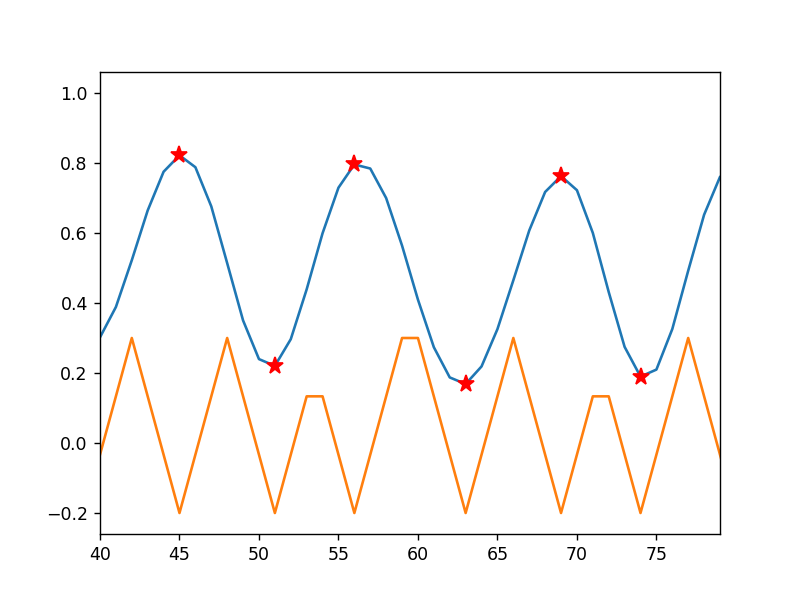

<IPython.core.display.Javascript object>


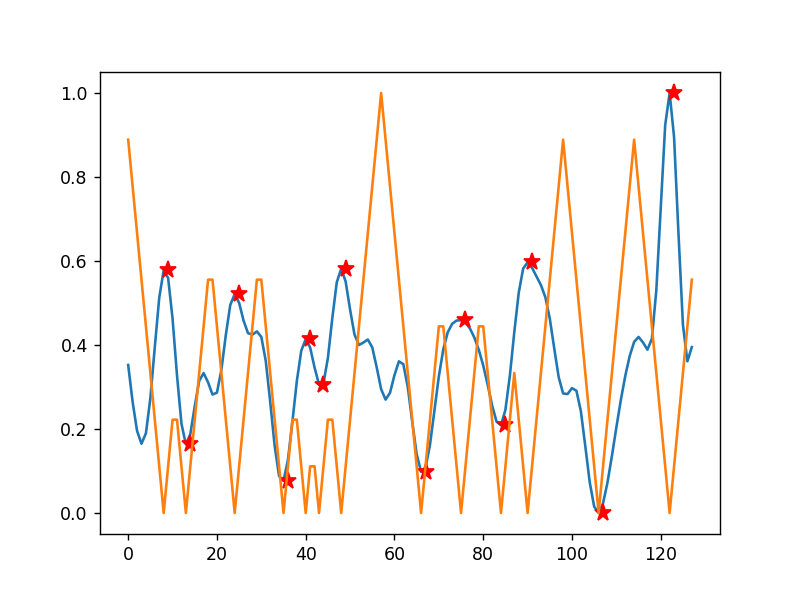

In [32]:
plt.figure(31)
plt.plot(signal_with_attn[274])
plt.plot(extremas_with_attn[274],signal_with_attn[274][extremas_with_attn[274]],'r*', markersize = 10)
plt.plot(dist_with_attention[274])
plt.xlim([40,79])
plt.show()


plt.figure(32)
plt.plot(signal_wo_attn[343])
plt.plot(extremas_wo_attn[343]+1,signal_wo_attn[343][extremas_wo_attn[343]],'r*', markersize = 10)
plt.plot(dist_wo_attention[343])
#plt.xlim([39,50])
plt.show()


In [33]:
# x1 = dist_with_attention[160]
# x2 = dist_wo_attention[160]
# y = dist_ref_resp[160]

In [34]:
final_error_with_attn = []
final_error_wo_attn = []
for i in range(814):
    x1 = dist_with_attention[i]
    x2 = dist_wo_attention[i]
    y = dist_ref_resp[i]

    #x1 = (x1-min(x1))/(max(x1) - min(x1))
    #x2 = (x2-min(x2))/(max(x2) - min(x2))
    #y = (y-min(y))/(max(y) - min(y))
    
    final_error_with_attn.append(np.mean(np.abs(x1-y)))
    final_error_wo_attn.append(np.mean(np.abs(x2-y)))

In [35]:
np.argmin(final_error_with_attn)

637

In [36]:
np.argmax(final_error_wo_attn)

511

In [37]:
min(final_error_with_attn)
idm = np.argmin(final_error_with_attn)
print(final_error_wo_attn[idm])
print(final_error_with_attn[idm])

0.24598524305555558
0.16909722222222223


In [38]:
x_attn = signal_with_attn[240]
x_wo_attn = signal_wo_attn[240]
y_ref = final_ref_resp_sig[240]
x_attn = (x_attn - min(x_attn))/(max(x_attn) - min(x_attn))
x_wo_attn = (x_wo_attn - min(x_wo_attn))/(max(x_wo_attn) - min(x_wo_attn))
y_ref = (y_ref - min(y_ref))/(max(y_ref) - min(y_ref))

<IPython.core.display.Javascript object>


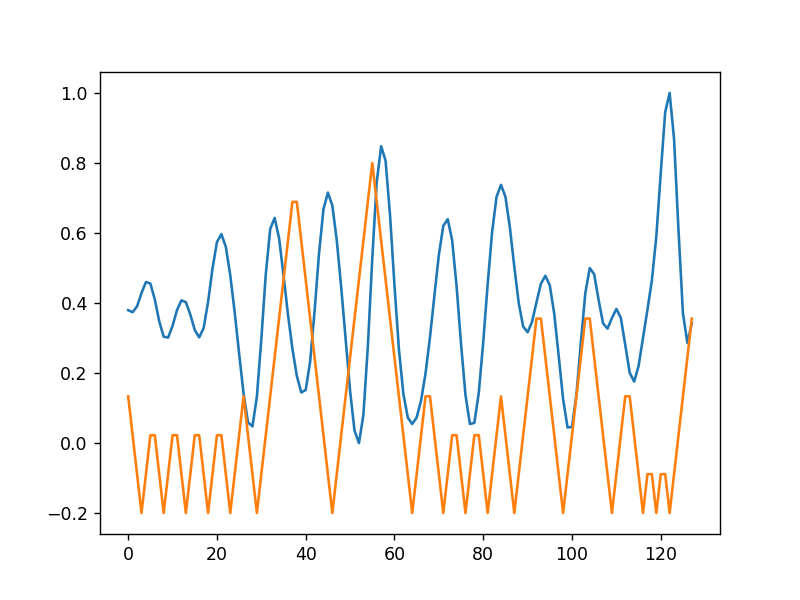

<IPython.core.display.Javascript object>


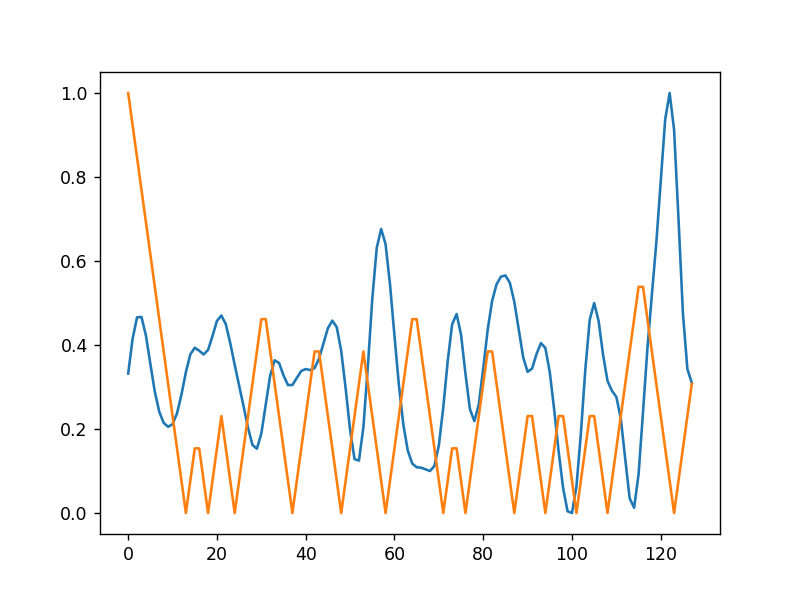

<IPython.core.display.Javascript object>


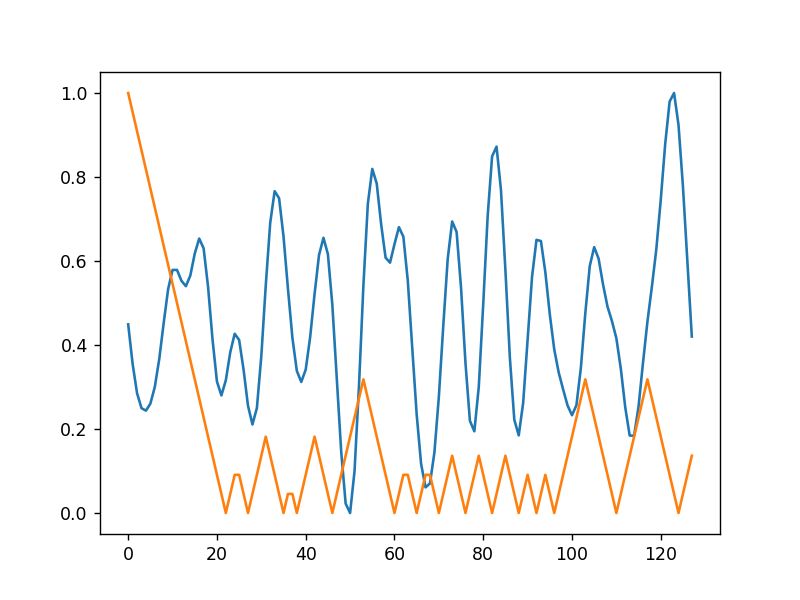

In [39]:
plt.figure(21)
plt.plot(x_attn)
plt.plot(x1)
plt.show()

plt.figure(22)
plt.plot(x_wo_attn)
plt.plot(x2)
plt.show()

plt.figure(23)
plt.plot(y_ref)
plt.plot(y)
plt.show()

In [40]:
final_corr_with_attn = []
final_corr_wo_attn = []
for i in range(814):
    x1 = dist_with_attention[i]
    x2 = dist_wo_attention[i]
    y = dist_ref_resp[i]

    #x1 = (x1-min(x1))/(max(x1) - min(x1))
    #x2 = (x2-min(x2))/(max(x2) - min(x2))
    #y = (y-min(y))/(max(y) - min(y))
    r1,p1 = scipy.stats.spearmanr(x2, y)
    r2,p2 = scipy.stats.spearmanr(x1, y)
    final_corr_with_attn.append((r1,p1))
    final_corr_wo_attn.append((r2,p2))

In [41]:
min

<function min>

In [42]:
print(np.mean(final_corr_with_attn))
print(np.mean(final_corr_wo_attn))

0.184563200938074
0.19432720589566213


In [43]:
final_corr_with_attn[159]

(0.7251892260763709, 3.6921149615458406e-22)

In [44]:
# x1 = signal_wo_attn[736]
# y1 = final_ref_resp_sig[736]
# r,p = scipy.stats.spearmanr(x1, y)
# print(r)

In [45]:
# error_wo_attn = np.abs(x1 - y)
# error_with_attn = np.abs(x2-y)

# print(np.mean(error_wo_attn))
# print(np.mean(error_with_attn))

In [46]:
error_diff = error_wo_att_block-error_with_att_block

In [47]:
index_error = np.argmax(error_diff)
max_diff = max(error_diff)
print(index_error)
print(max_diff)

117
[10.6605875]


In [48]:
#error_wo_att_block[]

In [49]:
sys.exit()

SystemExit: 

/home/acrophase/tf_gpu25/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3449: UserWarning:

To exit: use 'exit', 'quit', or Ctrl-D.



# ATTENTION WITH MONTE CARLO

In [ ]:
inf_sample = 10
if input_conf == 'confd':
    final_output = np.array([])
    final_output_rr = np.array([])
    final_attn1 = np.array([])
    final_attn2 = np.array([])
    final_attn3 = np.array([])
    final_attn4 = np.array([])
    final_attn5 = np.array([])
    final_attn6 = np.array([])
    final_attn7 = np.array([])
    final_attn8 = np.array([])
    final_attn9 = np.array([])
    model_input_shape = (128,3)
    model  = BRUnet_Multi_resp_ATT_MC(model_input_shape)
    loss_fn = Huber()
    model(tf.ones((128,128,3)))
    model.load_weights('/media/acrophase/pose1/charan/BR_Uncertainty/ATTENTION/SAVED_MODEL_ATT_MONTE/confd/best_model_50.01_0.0001_100.h5')
    start_unc = time.time()
    for i in tqdm.tqdm(range(inf_sample)):
        test_loss_list = []
        output_data = tf.convert_to_tensor([])
        output_data_rr = tf.convert_to_tensor([])
        attn1 = tf.convert_to_tensor([])
        attn2 = tf.convert_to_tensor([])
        attn3 = tf.convert_to_tensor([])
        attn4 = tf.convert_to_tensor([])
        attn5 = tf.convert_to_tensor([])
        attn6 = tf.convert_to_tensor([])
        attn7 = tf.convert_to_tensor([])
        attn8 = tf.convert_to_tensor([])
        attn9 = tf.convert_to_tensor([])
        for step , (x_batch_test,y_batch_test,x_batch_test_ref_rr) in enumerate(test_dataset):
            test_output,test_out_rr,at_1,at_2,at_3,at_4,at_5,at_6,at_7,at_8,at_9 = model(x_batch_test)
            test_loss_resp = loss_fn(y_batch_test  , test_output)
            test_loss_rr = loss_fn(x_batch_test_ref_rr , test_out_rr)
            test_loss = test_loss_resp + test_loss_rr
            if step == 0:
                output_data = test_output
                output_data_rr = test_out_rr
                attn1 = at_1
                attn2 = at_2
                attn3 = at_3
                attn4 = at_4
                attn5 = at_5
                attn6 = at_6
                attn7 = at_7
                attn8 = at_8
                attn9 = at_9
            else:
                output_data = tf.concat([output_data , test_output] , axis = 0)
                output_data_rr = tf.concat([output_data_rr , test_out_rr] , axis = 0)
                attn1 = tf.concat([attn1 , at_1] , axis = 0)
                attn2 = tf.concat([attn2 , at_2] , axis = 0)
                attn3 = tf.concat([attn3 , at_3] , axis = 0)
                attn4 = tf.concat([attn4 , at_4] , axis = 0)
                attn5 = tf.concat([attn5 , at_5] , axis = 0)
                attn6 = tf.concat([attn6 , at_6] , axis = 0)
                attn7 = tf.concat([attn7 , at_7] , axis = 0)
                attn8 = tf.concat([attn8 , at_8] , axis = 0)
                attn9 = tf.concat([attn9 , at_9] , axis = 0)
            test_loss_list.append(test_loss)
        output_array = output_data.numpy()
        output_array_rr = output_data_rr.numpy()
        attn1_array = attn1.numpy()
        attn2_array = attn2.numpy()
        attn3_array = attn3.numpy()
        attn4_array = attn4.numpy()
        attn5_array = attn5.numpy()
        attn6_array = attn6.numpy()
        attn7_array = attn7.numpy()
        attn8_array = attn8.numpy()
        attn9_array = attn9.numpy()
        output_array = output_array.reshape(output_array.shape[-1],output_array.shape[0],output_array.shape[1])
        output_array_rr = output_array_rr.reshape(output_array_rr.shape[-1],output_array_rr.shape[0],output_array_rr.shape[1])
        attn1_array = np.expand_dims(attn1_array,axis = 0)
        attn2_array = np.expand_dims(attn2_array,axis = 0)
        attn3_array = np.expand_dims(attn3_array,axis = 0)
        attn4_array = np.expand_dims(attn4_array,axis = 0)
        attn5_array = np.expand_dims(attn5_array,axis = 0)
        attn6_array = np.expand_dims(attn6_array,axis = 0)
        attn7_array = np.expand_dims(attn7_array,axis = 0)
        attn8_array = np.expand_dims(attn8_array,axis = 0)
        attn9_array = np.expand_dims(attn9_array,axis = 0)
        if i == 0:
            final_output = output_array
            final_output_rr = output_array_rr
            final_attn1 = attn1_array
            final_attn2 = attn2_array
            final_attn3 = attn3_array
            final_attn4 = attn4_array
            final_attn5 = attn5_array
            final_attn6 = attn6_array
            final_attn7 = attn7_array
            final_attn8 = attn8_array
            final_attn9 = attn9_array
        else:
            final_output = np.vstack((final_output,output_array))
            final_output_rr = np.vstack((final_output_rr,output_array_rr))
            final_attn1 = np.vstack((final_attn1,attn1_array))
            final_attn2 = np.vstack((final_attn2,attn2_array))
            final_attn3 = np.vstack((final_attn3,attn3_array))
            final_attn4 = np.vstack((final_attn4,attn4_array))
            final_attn5 = np.vstack((final_attn5,attn5_array))
            final_attn6 = np.vstack((final_attn6,attn6_array))
            final_attn7 = np.vstack((final_attn7,attn7_array))
            final_attn8 = np.vstack((final_attn8,attn8_array))
            final_attn9 = np.vstack((final_attn9,attn9_array))
    end_unc = time.time()    
#=================================================================================================================


In [ ]:
print(end_unc - start_unc)

In [ ]:
if input_conf == 'confd':
    #l = 0.1
    #drop_prob = 0.1
    #lam = 0.0001
    
    #l_rr = 0.01
    #drop_prob_rr = 0.1
    #lam_rr = 0.0001
    
    final_output_resp_sig = []
    inst_br_dur = []
    inst_ref_br_dur = []
    inst_rr = []
    inst_ref_rr = []
    
    final_attn1_output = np.mean(final_attn1 , axis = 0)
    final_attn2_output = np.mean(final_attn2 , axis = 0)
    final_attn3_output = np.mean(final_attn3 , axis = 0)
    final_attn4_output = np.mean(final_attn4 , axis = 0)
    final_attn5_output = np.mean(final_attn5 , axis = 0)
    final_attn6_output = np.mean(final_attn6 , axis = 0)
    final_attn7_output = np.mean(final_attn7 , axis = 0)
    final_attn8_output = np.mean(final_attn8 , axis = 0)
    final_attn9_output = np.mean(final_attn9 , axis = 0)
    
    final_output_resp = np.mean(final_output,axis = 0)
    final_rr = np.mean(final_output_rr,axis = 0)
    #tau = (l**2) * (1-drop_prob) / (2. * lam)
    #tau_rr = (l_rr**2) * (1-drop_prob_rr) / (2. * lam_rr)
    
    final_var = np.var(final_output,axis = 0)
    final_var_rr = np.var(final_output_rr,axis = 0)
    #final_var += (tau**-1)
    #final_var_rr += (tau_rr**-1)
    output_copy = final_output_resp
    output_copy_rr = final_rr
    std_dev = np.sqrt(final_var)
    std_dev_rr = np.sqrt(final_var_rr)
    for item in final_output_resp:
        final_output_resp_sig.append(scipy.signal.filtfilt(fbpB,fbpA , item))
        
    final_output_resp_sig = np.array(final_output_resp_sig)
    duration_resp,extremas_resp = extremas_extraction(final_output_resp_sig)
    duration_ref_resp,extremas_ref_resp = extremas_extraction(final_ref_resp_sig)
    avg_ref_breath = (60*4/duration_ref_resp).reshape(-1,1)
    
    error_avg_breaths = np.abs(avg_ref_breath - final_rr)
    mae_avg_breath = np.mean(error_avg_breaths)
    rmse_avg_breath = np.sqrt(np.mean(error_avg_breaths**2))
    
    for item in extremas_resp:
        inst_br_dur.append(np.diff(item[0::2]))
    for item in extremas_ref_resp:
        inst_ref_br_dur.append(np.diff(item[0::2]))
    for item in inst_br_dur:
        inst_rr.append(np.mean(60*4/item))
    for item in inst_ref_br_dur:
        inst_ref_rr.append(np.mean(60*4/item))
    
    inst_rr = (np.array(inst_rr)).reshape(-1,1)
    inst_ref_rr = (np.array(inst_ref_rr)).reshape(-1,1)
    
    error_inst_breaths = np.abs(inst_ref_rr - inst_rr)
    mae_inst_breath = np.mean(error_inst_breaths)
    rmse_inst_breath = np.sqrt(np.mean(error_inst_breaths**2))
    
    samples = np.arange(0,len(final_rr)).reshape(-1,1)
    confd_data = np.hstack((samples,final_rr , std_dev_rr,error_avg_breaths, error_inst_breaths))
    col_confd = ['Samples','Final RR Output (BrPM)' , 'Uncertainty', 'Error Average RR(BrPM)','Error Instantaneous RR(BrPM)']
    data_confd = pd.DataFrame(confd_data , columns = col_confd)
    
    print('Mean Absolute Error average wise for {} is: {}'.format(input_conf,mae_avg_breath))
    print('Root Mean Square Error average wise for {} is: {}'.format(input_conf,rmse_avg_breath))
    
    print('Mean Absolute Error instantaneous wise for {} is: {}'.format(input_conf,mae_inst_breath))
    print('Root Mean Square Error instantaneous wise for {} is: {}'.format(input_conf,rmse_inst_breath))
    
#===================================================================================================================


In [ ]:
if input_conf == 'confd':
    no_of_samples = 32*4
    x_unc = np.linspace(start = 0,stop = no_of_samples, num = no_of_samples)
    layout_epistemic = go.Layout(
    title = "Respiratory Waveform with Epistemic Uncertainty for "+ input_conf.upper(),
    yaxis = dict(
        title = 'Output Respiration Signal' 
    ),
    xaxis = dict(
        title = 'samples'
    )
    )
    def update_plot(signals):
        data = []
            # Reference ECG trace
        trace_epistemic = go.Scatter(
            x = x_unc,
            y = final_output_resp_sig[signals], 
            mode = 'lines',
            name = 'Respiration with Epistemic',
                    line = dict(
                    shape = 'spline',
                    color = 'red',
                    width = 5
                     ),
                error_y=dict(
                    type='data', # value of error bar given in data coordinates
                    array=final_var[signals],
                    visible=True,
                    color='black',
                thickness=3,
                width=5)
                )
        fig_epistemic = go.Figure(data = [trace_epistemic],layout = layout_epistemic)
        py.offline.iplot(fig_epistemic)
signals_epsitemic = widgets.IntSlider(min = 0,max = len(final_output_resp_sig), value = 0, description = 'Record_no:')
widgets.interactive(update_plot, signals = signals_epsitemic)

In [ ]:

if input_conf == 'confd':
    fig1 = px.scatter(data_confd,x = 'Samples', y="Error Average RR(BrPM)",
                     color="Uncertainty", color_continuous_scale=px.colors.sequential.Plasma,size='Uncertainty')
  
    fig1.update_yaxes(title_font=dict(size=18),tickfont = dict(size=14))
    fig1.update_xaxes(title_font=dict(size=18),tickfont = dict(size=14))  
    fig1.update_coloraxes(colorbar_tickfont=dict(size = 14))
    fig2 = px.scatter(data_confd,x = 'Samples', y="Error Instantaneous RR(BrPM)",
                     color="Uncertainty", color_continuous_scale=px.colors.sequential.Plasma,size='Uncertainty')
    
    fig2.update_yaxes(title_font=dict(size=18),tickfont = dict(size=14))
    fig2.update_xaxes(title_font=dict(size=18),tickfont = dict(size=14))
    fig2.update_coloraxes(colorbar_tickfont=dict(size = 14))
    fig1.show()
    fig2.show()
     



In [ ]:
# fig2 = px.subplots.make_subplots(rows=1,cols=2)

# fig2.add_trace(fig1,1,1)
# fig2.show()

In [ ]:
if input_conf == 'confd' or input_conf == 'conff':
    if input_conf == 'confd':
        high_unc_index = np.where(std_dev_rr>0.9)
    elif input_conf == 'conff':
        high_unc_index = np.where(std_dev_rr>1.0)        
    for item in high_unc_index[0]:
        error_avg_breaths[item] = 0
        error_inst_breaths[item] = 0
    mae_avg_new = np.mean(error_avg_breaths)
    rmse_avg_breath_new = np.sqrt(np.mean(error_avg_breaths**2))
    mae_inst_new = np.mean(error_inst_breaths)
    rmse_inst_breath_new = np.sqrt(np.mean(error_inst_breaths**2))
    print('Mean Absolute Error average wise for {} is: {}'.format(input_conf,mae_avg_new))
    print('Root Mean Square Error average wise for {} is: {}'.format(input_conf,rmse_avg_breath_new))
    
    print('Mean Absolute Error instantaneous wise for {} is: {}'.format(input_conf,mae_inst_new))
    print('Root Mean Square Error instantaneous wise for {} is: {}'.format(input_conf,rmse_inst_breath_new))



In [ ]:
len(high_unc_index[0])

In [ ]:
# print(final_attn1_output.shape)
# print(final_attn2_output.shape)
# print(final_attn3_output.shape)
# print(final_attn4_output.shape)
# print(final_attn5_output.shape)
# print(final_attn6_output.shape)
# print(final_attn7_output.shape)
# print(final_attn8_output.shape)
# print(final_attn9_output.shape)

In [ ]:
# plt.figure(5)
# plt.plot(final_attn5_output.transpose(0,2,1)[0][7])
# plt.show()

In [ ]:

new_attn5 = final_attn5_output.transpose(0,2,1)
new_attn6 = final_attn6_output.transpose(0,2,1)
new_attn7 = final_attn7_output.transpose(0,2,1)
new_attn8 = final_attn8_output.transpose(0,2,1)
new_attn9 = final_attn9_output.transpose(0,2,1)
new_attn1 = final_attn1_output.transpose(0,2,1)
x_attn1 = new_attn1[0][7]
x_attn5 = new_attn5[0][0]
x_attn6 = new_attn6[0][0]
x_attn7 = new_attn7[0][0] #5
x_attn8 = new_attn8[0][0] #8,11,12,13
x_attn9 = new_attn9[0][2]  #5,23,31,32,47,48,49,50,51,62,63.

x_attn1 = (x_attn1 - min(x_attn1))/(max(x_attn1) - min(x_attn1))
x_attn5 = (x_attn5 - min(x_attn5))/(max(x_attn5) - min(x_attn5))
x_attn6 = (x_attn6 - min(x_attn6))/(max(x_attn6) - min(x_attn6))
x_attn7 = (x_attn7 - min(x_attn7))/(max(x_attn7) - min(x_attn7))
x_attn8 = (x_attn8 - min(x_attn8))/(max(x_attn8) - min(x_attn8))
x_attn9 = (x_attn9 - min(x_attn9))/(max(x_attn9) - min(x_attn9))

figure,axes = plt.subplots(nrows = 2 , ncols = 3,figsize=(12,6))

axes[0,0].plot(x_attn1,linewidth=3)
axes[0,0].set_title("Fig.(A)" , fontsize = 16)
axes[0,0].set_xlabel("BottleNeck Feature Map" , fontsize = 14)
#=================================================================================
axes[0,1].plot(x_attn5,linewidth=3)
axes[0,1].set_title("Fig.(B)" , fontsize = 16)
axes[0,1].set_xlabel("First Attention Feature Map" , fontsize = 14)
#==================================================================================
axes[0,2].plot(x_attn6,linewidth=3)
axes[0,2].set_title("Fig.(C)" , fontsize = 16)
axes[0,2].set_xlabel("Second Attention Feature Map" , fontsize = 14)
#==================================================================================
axes[1,0].plot(x_attn7,linewidth=3)
axes[1,0].set_title("Fig.(D)" , fontsize = 16)
axes[1,0].set_xlabel("Third Attention Feature Map" , fontsize = 14)
# axes[1,0].annotate('axes fraction',
#             xy=(5, 0), xycoords='data',
#             xytext=(0.8, 0.95), textcoords='axes fraction',
#             arrowprops=dict(facecolor='black', shrink=0.05))
axes[1,1].plot(x_attn8,linewidth=3)
axes[1,1].set_title("Fig.(E)" , fontsize = 16)
axes[1,1].set_xlabel("Fourth Attention Feature Map" , fontsize = 14)
axes[1,2].plot(x_attn9,linewidth=3)
axes[1,2].set_title("Fig.(F)" , fontsize = 16)
axes[1,2].set_xlabel("Fifth Attention Feature Map" , fontsize = 14)
#plt.rcParams["figure.figsize"] = (10,5)
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.2, 
                    hspace=0.6)
#figure.tight_layout()
#plt.savefig("attn_feature_maps.jpg")

In [ ]:
x_attn9.shape

In [ ]:
# x_attn1 = final_attn1_output[0][7]
# x_attn2 = final_attn2_output[0][3]
# x_attn3 = final_attn3_output[0][1]
# x_attn4 = final_attn4_output[0][0]

# figure1,axes1 = plt.subplots(nrows = 2 , ncols = 2)

# axes1[0,0].plot(x_attn1)
# axes1[0,1].plot(x_attn2)
# axes1[1,0].plot(x_attn3)
# axes1[1,1].plot(x_attn4)

# figure1.tight_layout()

In [ ]:
x = np.array([5,10,15,20])
#y = [4.8,3.94,3.88,3.8]
y_ppg = np.array([3.73,3,3.04,2.91])
t_ppg = np.array([8,13.9,20.32,27.76])

y_ir = np.array([3.63,2.97,3.02,3.03])
t_ir = np.array([7.16,12.08,17.54,23.06])

In [ ]:
y_ppg = (y_ppg-min(y_ppg))/(max(y_ppg) - min(y_ppg))
t_ppg = (t_ppg-min(t_ppg))/(max(t_ppg) - min(t_ppg))

y_ir = (y_ir-min(y_ir))/(max(y_ir) - min(y_ir))
t_ir = (t_ir-min(t_ir))/(max(t_ir) - min(t_ir))

In [ ]:
fig,ax = plt.subplots(nrows = 1 , ncols = 2,figsize=(12,6))
ax[0].plot(x,y_ppg,linewidth=3 , label = "Normalized MAE")
ax[0].plot(x,t_ppg,linewidth=3, label = "Normalized Inference time")
ax[0].legend(loc = 'upper center',fontsize = 12)
ax[0].set_xlabel("Number of Inference Samples" , fontsize = 14)
ax[0].set_ylabel("Normalized Parameters" , fontsize = 14)
ax[0].set_title("Fig (A): PPG DALIA", fontsize = 16)

ax[1].plot(x,y_ir,linewidth=3 , label = "Normalized MAE")
ax[1].plot(x,t_ir,linewidth=3, label = "Normalized Inference time")
ax[1].legend(loc = 'upper center',fontsize = 12)
ax[1].set_xlabel("Number of Inference Samples" , fontsize = 14)
ax[1].set_ylabel("Normalized Parameters" , fontsize = 14)
ax[1].set_title("Fig (B): IR DATASET", fontsize = 16)
plt.savefig("Error_Time_Unc.jpg")

In [ ]:
# plt.figure(25)
# plt.plot(x,y,label = "Normalized MAE")
# plt.plot(x,t , label = "Normalized Inference time")
# plt.legend(loc = 'upper center',fontsize = 12)
# plt.xlabel("Number of Inference Samples" , fontsize = 14)
# plt.ylabel("Normalized Parameters" , fontsize = 14)
# plt.xticks(fontsize = 12)
# plt.yticks(fontsize = 12)
# plt.title("Figure A: PPG DALIA")
# plt.savefig("ppg_dalia_error_time.jpg")
# plt.show()